## Analyzing A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working on an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

- Import my libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- Reading the dataset and taking a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


- The number of rows in the dataset.

In [3]:
df.shape[0]

294478

- The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

- The proportion of users converted.

In [5]:
sum(df['converted']==1)/df.user_id.nunique()

0.12126269856564711

- The number of times the `new_page` and `treatment` don't match.

In [6]:
sum((df.group=='treatment')|(df.landing_page=='new_page'))-sum((df.group=='treatment')&(df.landing_page=='new_page'))

3893

- Cheching if any of the rows have missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No missing values.**

*For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page.*

- Now I create a new dataset and store my new dataframe in **df2**.

In [8]:
df2 = df.query('(group=="treatment"&landing_page=="new_page")|(group=="control"&landing_page=="old_page")')

In [9]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

- Checking number of unique **user_id**s are in **df2**.

In [10]:
df2.user_id.nunique()

290584

- There is one **user_id** repeated in **df2**.  Let's see What is it.

In [11]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


773192

- Cheching the row information for the repeat **user_id**.

In [12]:
df2[df2['user_id'].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- Removing **one** of the rows with a duplicate **user_id**.

In [13]:
df2 = df2.drop(2893)
sum(df2['user_id'].duplicated())

0

- The probability of an individual converting regardless of the page they receive.

In [14]:
sum(df2.converted==1)/df2.shape[0]

0.11959708724499628

- The probability that an individual was in the `control` group converts.

In [15]:
sum((df2.group=='control')&(df2.converted==1))/sum(df2.group=='control')

0.1203863045004612

- The probability that an individual was in the `treatment` group converts. 

In [16]:
sum((df2.group=='treatment')&(df2.converted==1))/sum(df2.group=='treatment')

0.11880806551510564

- The probability that an individual received the new page?

In [17]:
sum(df2.landing_page=='new_page')/df2.shape[0]

0.5000619442226688

**I think there is no yet sufficient evidence in my above results to conclude that the new treatment page leads to more conversions. Let's see what A/B test says.**

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is can I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


*For now, I consider I need to make the decision just based on all the data provided. I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, My null hypothes is H0: P(new)-P(old)<=0, and my alternative hypothes is H1: P(new)-P(old)>0.*

I assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

I use a sample size for each page equal to the ones in **ab_data.csv**.

I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

- The conversion rate for $p_{new}$ under the null.

In [18]:
pn = sum(df2.converted==1)/df2.shape[0]
pn

0.11959708724499628

- The conversion rate for $p_{old}$ under the null.

In [19]:
po = sum(df2.converted==1)/df2.shape[0]
po

0.11959708724499628

- The number of individuals in the treatment group $n_{new}$.

In [20]:
nn = sum(df2.group=='treatment')
nn

145310

- The number of individuals in the control group $n_{old}$.

In [21]:
no = sum(df2.group=='control')
no

145274

- Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null and storing these $n_{new}$ 1's and 0's in new_page_converted.

In [22]:
rn = int(nn*pn)
new_page_converted = df2[df2['landing_page']=='new_page'].sample(rn)
new_page_converted.head(2)

,user_id,timestamp,group,landing_page,converted
248884,938682,2017-01-08 18:03:10.221517,treatment,new_page,1
129120,755407,2017-01-15 05:17:53.197732,treatment,new_page,0


- Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and storing these $n_{old}$ 1's and 0's in old_page_converted.

In [23]:
ro = int(no*po)
old_page_converted = df2[df2['landing_page']=='old_page'].sample(ro)
old_page_converted.shape

(17374, 5)

- $p_{new}$ - $p_{old}$.

In [24]:
pn-po

0.0

- Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process I used above and storing all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs=[]
for _ in range(10000):
    sn = new_page_converted.sample(rn, replace=True)
    so = old_page_converted.sample(ro, replace=True)
    p_n = sum(sn.converted==True)/sn.shape[0]
    p_o = sum(so.converted==True)/sn.shape[0]
    p_diff = p_n-p_o
    p_diffs.append(p_diff)
p_diffs = np.array(p_diffs)

- Plotting a histogram of the **p_diffs**.

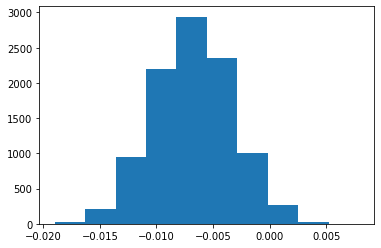

In [26]:
plt.hist(p_diffs);

In [27]:
obs_diff = df2.query('group=="treatment"').converted.mean() - df2.query('group=="control"').converted.mean()
obs_diff

-0.0015782389853555567

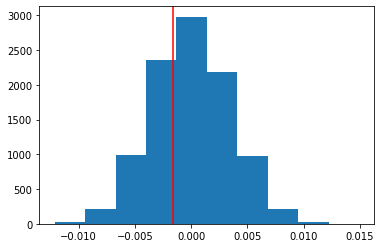

In [28]:
null_vals=np.random.normal(loc=0, scale=p_diffs.std(), size=10000);
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

In [29]:
p_value = (p_diffs>obs_diff).mean()
p_value

0.0654

**The result P_value means that I failed to reject the null hypothesis because P_value is greater than alpha, which means that the old page is equal or better than the new page.**

*I can also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.*

- Calculating the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = sum((df2.landing_page=='old_page')&(df2.converted==1))
convert_new = sum((df2.landing_page=='new_page')&(df2.converted==1))
n_old = sum(df2.landing_page=='old_page')
n_new = sum(df2.landing_page=='new_page')

- Using `stats.proportions_ztest` to compute my test statistic and p-value.

In [31]:
sm.stats.proportions_ztest(count=np.array([convert_old,convert_new]), nobs=np.array([n_old,n_new]), value=0, alternative='smaller', prop_var=False)

(1.3109241984234394, 0.9050583127590245)

**The z-score and p-value I computed show that I failed to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

*In this final part, I want to make sure of the result I achieved in the A/B test in Part II above by performing regression.*

*Since each row is either a conversion or no conversion, I will use **Logistic Regression**.*

- The goal is to use **statsmodels** to fit the regression model I specified to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, create a dummy variable column for which page each user received, add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept']=1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


- Using **statsmodels** to instantiate my regression model on the two columns I created, then fitting the model to predict whether or not an individual converts. 

In [33]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:25:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

- Providing the summary of my model.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:25:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value associated with ab_page is 0.190.
It is higher than that I got from part II, because here I am performing two tailed test but in Part II I performed one tailed test.**

*Now, I am considering other things that might influence whether or not an individual convert like the country to know the influence of all factors on the result of conversion.*

In [35]:
df3 = pd.read_csv('countries.csv')
df2 = df2.merge(df3, on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [36]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [37]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'US', 'UK']])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:               1.521e-05
Time:                        21:25:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

*Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion.*

In [38]:
df2['UK_ab_page'] = df2['UK']*df2['ab_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,UK_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0


In [39]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK_ab_page', 'UK']])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:               2.036e-05
Time:                        21:25:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9876      0.009   -213.551      0.000      -2.006      -1.969
ab_page       -0.0236      0.013     -1.788      0.074      -0.050       0.002
UK_ab_page     0.0345      0.026      1.307      0.191      -0.017       0.086
UK            -0.0046      0.019     -0.247      0.805      -0.041       0.032
==============================================================================
"""

In [40]:
df2['US_ab_page'] = df2['US']*df2['ab_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,UK_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [41]:
lg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US_ab_page', 'US']])
results = lg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:               1.077e-05
Time:                        21:25:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.5143
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9942      0.015   -135.158      0.000      -2.023      -1.965
ab_page       -0.0019      0.021     -0.093      0.926      -0.043       0.039
US_ab_page    -0.0186      0.025     -0.746      0.456      -0.068       0.030
US             0.0077      0.018      0.436      0.663      -0.027       0.042
==============================================================================
"""

# Conclusions:

In Part I, In all model I failed to reject the null hypothesis because the p-value is higher alpha **(P-value > Alpha)** (First type error) Which means than the older page is equal or better than the new one (Null hypothesis).

In part II, I get the same results from Logistic regression model which means that we also can't reject the null hypothesis so that the older page is equal or better than the new one.

After adding country column in mind, I found that the country doesn't matter so much in conversion result.